In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


import seaborn as sns

from sklearn.model_selection import train_test_split

from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP import confusion_table
from ISLP.models import contrast

import sklearn
from sklearn import metrics
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
        RandomForestClassifier as RC,
      GradientBoostingRegressor as GBR, 
        GradientBoostingClassifier as GBC)
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions 

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#  MCC
from sklearn.metrics import matthews_corrcoef
#from sklearn.metrics import confusion_matrix



/root/anaconda3/envs/3.20_env/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# Preprocessing.

In [2]:
df = pd.read_csv(r'Customer-Churn.csv')

np.random.seed(3141592)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print(\
len( df [df['Churn'] == 1] ) / df.shape[0] *100, '% of our customers were lost')

0.0 % of our customers were lost


In [4]:
features = [i for i in df.columns]

# pd.DataFrame( {'feature': [i for i in features] , 'data type':[viz_df[i].dtype for i in features]  })

unique_values=[]
for i in features:
    unique_values.append([item for item in df[i].unique()])

pd.DataFrame({'features': [i for i in features], 'unique_values': [list for list in unique_values], 'data type':[df[i].dtype for i in features]})

,features,unique_values,data type
0,customerID,"[7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOC...",object
1,gender,"[Female, Male]",object
2,SeniorCitizen,"[0, 1]",int64
3,Partner,"[Yes, No]",object
4,Dependents,"[No, Yes]",object
5,tenure,"[1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, ...",int64
6,PhoneService,"[No, Yes]",object
7,MultipleLines,"[No phone service, No, Yes]",object
8,InternetService,"[DSL, Fiber optic, No]",object
9,OnlineSecurity,"[No, Yes, No internet service]",object


In [5]:
df = df.drop (['customerID'], axis = 1)                                                              # Drop customerID column
df.drop( labels = df[df ['tenure'] == 0].index, axis = 0, inplace = True )                           # Drop customer rows with 0 for tenure

mapping_dict = {'Yes':1, 'No': 0, 'Male': 1, 'Female': 0, 1:1, 0:0 }                                 # One-hot encoding binary attributes

bin_attr = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in bin_attr + ["Churn"]:
    df[col] = df[col].map(mapping_dict)
df2 = df                                                # dataframe for Christian's Visualizations
y = df['Churn']
X = df.drop(columns=['Churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)      #Running the split function twice to separate the data into 3 sets, Split is .6 Train, .2 Test, .2 Validation/holdout

#Separation of data types
num_attr = ['tenure', 'MonthlyCharges', 'TotalCharges']                                                    # numerical attributes/features
cat_attr = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',\
'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']          # categorical attributes/features

num_transformer_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

bin_transformer = 'passthrough'         #Did this in the data cleaning step, so this will tell ColumnTransformer() to not change anything
cat_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer_pipeline, num_attr),
        ('bin', bin_transformer, bin_attr),
        ('cat', cat_transformer, cat_attr)
    ])
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)
df_transformed = preprocessor.fit_transform(df)


In [6]:
# Make sure X_train_transformed is a NumPy array of floats
X_train_transformed = np.array(X_train_transformed, dtype=float)
X_test_transformed = np.array(X_test_transformed, dtype=float)
df_transformed = np.array(df_transformed, dtype=float)

In [7]:
# Transforming X_train_transformed into a dataframe for modeling
num_columns = num_attr  # These are the original numerical columns
bin_columns = bin_attr  # These are the binary columns
cat_columns = preprocessor.transformers_[2][1].get_feature_names_out(cat_attr)      # One-hot encoded column names
# Combine all column names
all_columns = np.concatenate([num_columns, bin_columns, cat_columns])

# Create the DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=all_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=all_columns)
df_transformed = pd.DataFrame(df_transformed, columns=all_columns)

# Display the first few rows of the DataFrame
df_transformed.head()

,tenure,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.280248,-1.161694,-0.994194,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.064303,-0.260878,-0.173740,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-1.239504,-0.363923,-0.959649,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.512486,-0.747850,-0.195248,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.239504,0.196178,-0.940457,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# EDA/Visualizations

### Isaac

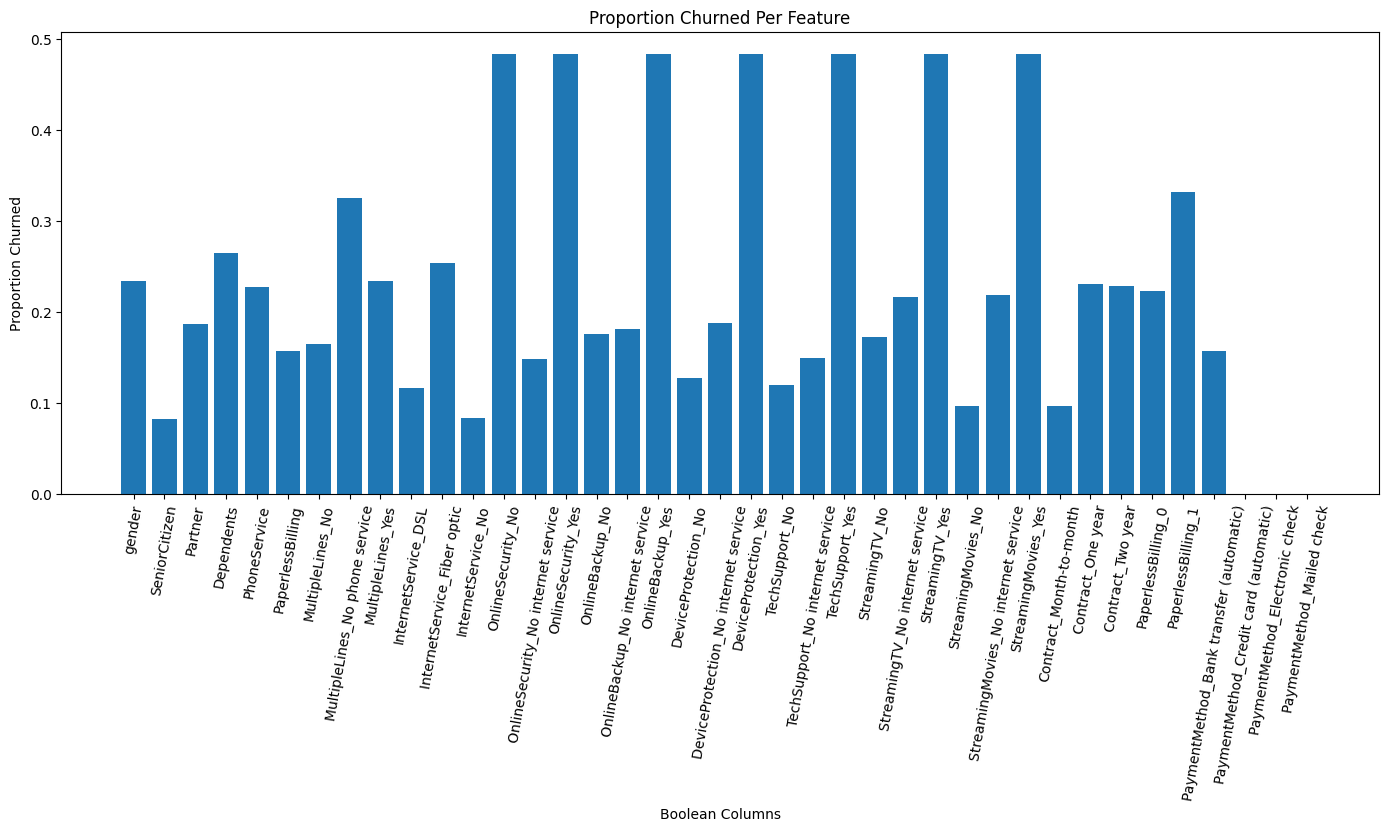

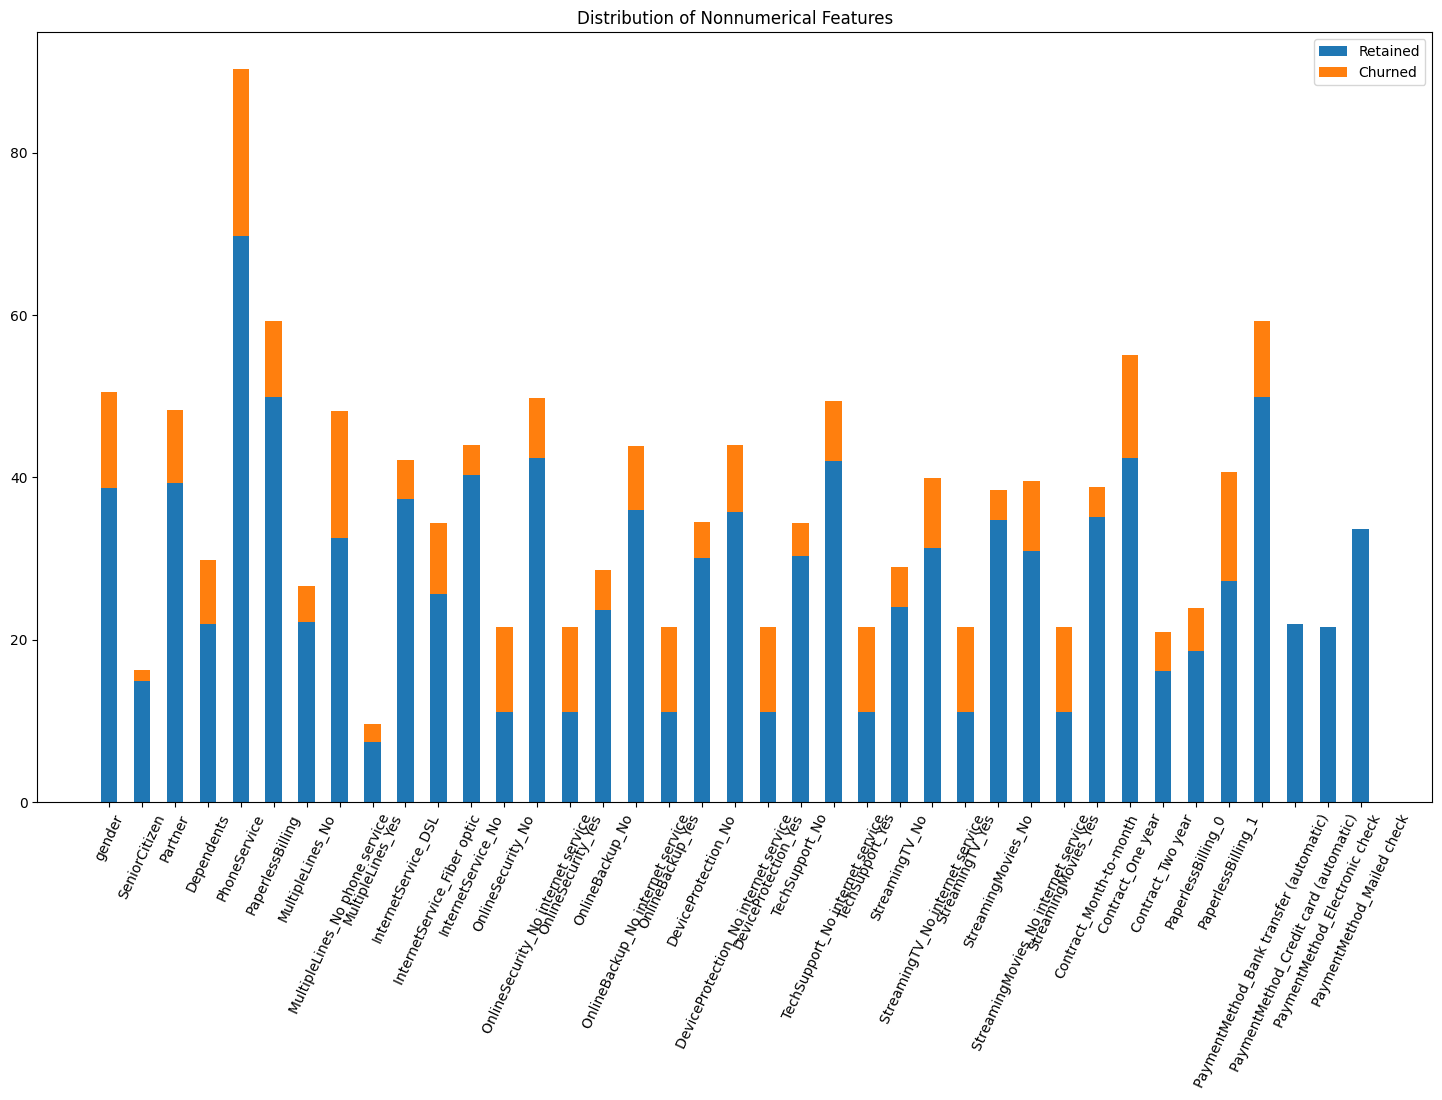

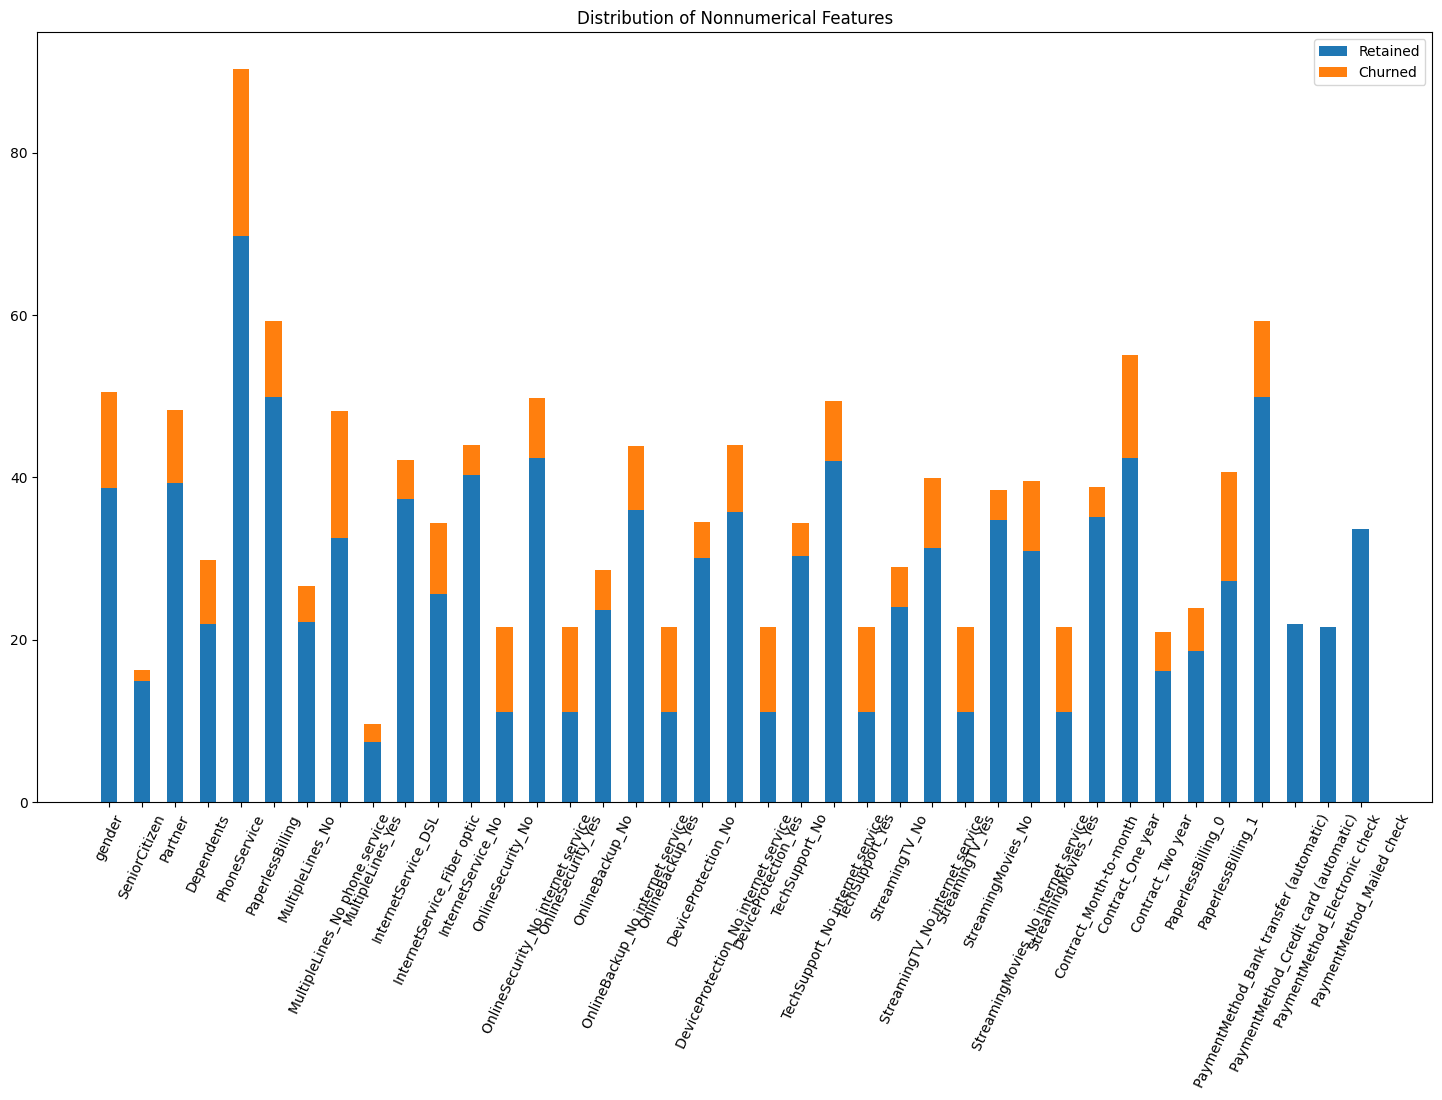

In [8]:
viz_bin_attr = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling','Churn']
preprocessor_for_viz = ColumnTransformer(
    transformers = [
        ('num', num_transformer_pipeline, num_attr),
        ('bin', bin_transformer, viz_bin_attr),
        ('cat', cat_transformer, cat_attr)
    ])
viz_array = preprocessor_for_viz.fit_transform(df)
viz_all_columns = np.concatenate([num_columns, bin_columns, cat_columns, ['Churn']])
viz_df = pd.DataFrame(viz_array, columns=viz_all_columns)

#bllock
binary_for_viz =[]
for col in viz_df.columns:
    if col != 'tenure' and col != 'MonthlyCharges' and col != 'TotalCharges' and col != 'Churn':
        binary_for_viz.append(col)
#block
churned_proportion=[]
for col in binary_for_viz:
    churned_proportion.append( len(viz_df [ (viz_df [col] == 1) & (viz_df['Churn'] == 1)]) / len(viz_df [ viz_df [col] ==1])  )


plt.figure(figsize=(17,6))
plt.bar(binary_for_viz, churned_proportion)
plt.xlabel('Boolean Columns')
plt.ylabel('Proportion Churned')
plt.title('Proportion Churned Per Feature')
plt.xticks(rotation = 80)
plt.show()

#block


# bool_cols = ["Partner","Dependents","PhoneService","PaperlessBilling", 'male','female', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
dict = {'Retained': [], 'Churned': []}
churned = []
retained = []

for col in binary_for_viz:
    if col != 'Churn':
        churned.append(len(viz_df [ (viz_df[col] == 1) & (viz_df['Churn'] == 1 )])\
        / len(viz_df) *100)

        retained.append(len(viz_df [ (viz_df[col] == 1) & (viz_df['Churn'] == 0 )])\
        / len(viz_df) *100)
dict['Retained'] = retained
dict['Churned'] = churned

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(39)

for boolean, percent in dict.items():
    p = ax.bar([i for i in binary_for_viz if i != 'Churn'], percent, width, label=boolean, bottom=bottom)
    bottom += percent

ax.set_title('Distribution of Nonnumerical Features')
ax.legend(loc="upper right")
fig.set_size_inches(18, 10)

plt.xticks(rotation = 65)
plt.show()

#block


# bool_cols = ["Partner","Dependents","PhoneService","PaperlessBilling", 'male','female', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
dict = {'Retained': [], 'Churned': []}
churned = []
retained = []

for col in binary_for_viz:
    if col != 'Churn':
        churned.append(len(viz_df [ (viz_df[col] == 1) & (viz_df['Churn'] == 1 )])\
        / len(viz_df) *100)

        retained.append(len(viz_df [ (viz_df[col] == 1) & (viz_df['Churn'] == 0 )])\
        / len(viz_df) *100)
dict['Retained'] = retained
dict['Churned'] = churned

width = 0.5
fig, ax = plt.subplots()
bottom = np.zeros(39)

for boolean, percent in dict.items():
    p = ax.bar([i for i in binary_for_viz if i != 'Churn'], percent, width, label=boolean, bottom=bottom)
    bottom += percent

ax.set_title('Distribution of Nonnumerical Features')
ax.legend(loc="upper right")
fig.set_size_inches(18, 10)

plt.xticks(rotation = 65)
plt.show()


In [9]:
churned_proportion_df = pd.DataFrame({'cols':binary_for_viz, 'churned_proportion':churned_proportion})
churned_proportion_df.sort_values('churned_proportion', ascending=False)[:10]



,cols,churned_proportion
23,TechSupport_Yes,0.483553
29,StreamingMovies_Yes,0.483553
26,StreamingTV_Yes,0.483553
17,OnlineBackup_Yes,0.483553
20,DeviceProtection_Yes,0.483553
12,OnlineSecurity_No,0.483553
14,OnlineSecurity_Yes,0.483553
34,PaperlessBilling_1,0.331355
7,MultipleLines_No phone service,0.324963
3,Dependents,0.264412


### Rapunzel PCA

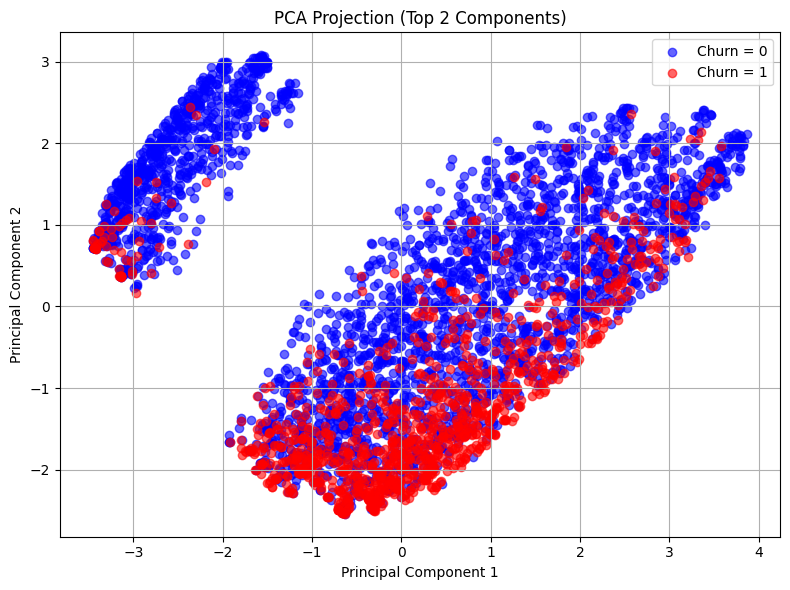

In [10]:
# Step 1: Apply PCA (2 components for plotting)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_transformed)

# Step 2: Combine with labels
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Churn'] = y_train.values  # Make sure y_train is still aligned

# Step 3: Plot
plt.figure(figsize=(8, 6))
for label, color in zip([0, 1], ['blue', 'red']):
    subset = pca_df[pca_df['Churn'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Churn = {label}', alpha=0.6, c=color)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (Top 2 Components)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Christian Visualizations

#### Customer Contract Types

In [13]:
fig = px.histogram(df2, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

#### Customer InternetService types

In [14]:
fig = px.histogram(df2, x="Churn", color="InternetService", barmode="group", 
                   title="<b>Customer InternetService Distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

# Modeling Start

### Rapunzel Logistic Regression

Accuracy: 0.7981520966595593

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1041
           1       0.63      0.56      0.59       366

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407


Confusion Matrix:
 [[919 122]
 [162 204]]


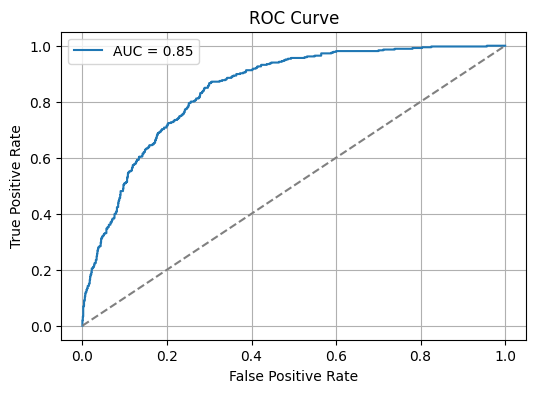

In [16]:
# Fit logistic regression on the preprocessed data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_transformed, y_train)

# Predict
y_pred = logreg.predict(X_test_transformed)
y_prob = logreg.predict_proba(X_test_transformed)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [17]:
# Accuracy on training data
train_accuracy = logreg.score(X_train_transformed, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.8060692271218587


### P-Values

In [18]:
X_const = sm.add_constant(X_train_transformed)


y_binary = pd.Series((y_train == 'Yes').astype(int))

# Fit logistic regression
logit_model = sm.Logit(y_binary, X_const)
result = logit_model.fit()

# Summary with coefficients and p-values
print(result.summary())

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4218
Model:                          Logit   Df Residuals:                     4194
Method:                           MLE   Df Model:                           23
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                     inf
Time:                        18:58:43   Log-Likelihood:            -1.6025e-06
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0024   2.79e+16  -2.15e-16      1.000   -5.46e+16    5.46e+16
x1            -2.6224   3.51e+09  -7.47e-10      1.000   -6.88e+0

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\U

### Isaac XGBoost

In [19]:
# we add an intercept column to the transformed training dataframe
X_train_transformed_df['intercept'] = np.ones(X_train_transformed_df.shape[0])
X_test_transformed_df['intercept'] = np.ones(X_test_transformed_df.shape[0])

In [20]:
# Ensure the indices of X_train_transformed_df and y_train match
X_train_transformed_df.index = y_train.index

# Ensure the indices of X_test_transformed_df and y_test match
X_test_transformed_df.index = y_test.index

Note to self: just changed gbm_auto = GBR to
gbm_auto = sklearn.ensemble.GradientBoostingClassifier
and the loss = param to 'log_loss

In [39]:
X_train = X_train_transformed_df
y_train = y_train

X_test = X_test_transformed_df

Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

gbm_auto = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.01,
               n_estimators=1000,
               max_depth=6,
               min_samples_split = 13,
               max_features = 6,
               loss = 'log_loss',
               random_state=314)
gbm_auto.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=6,
                           min_samples_split=13, n_estimators=1000,
                           random_state=314)

80.7% accuracy: max_depth = 3, lambda=10

80.81% accuracy: max_depth = 3, lambda = 1, gamma = 1, tree_method = exact

80.95: same above except tree_method = approx

In [40]:
X_train = X_train_transformed_df
y_train = y_train

X_test = X_test_transformed_df

Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

xgbm_auto = xgb.XGBClassifier(learning_rate=0.01,
               n_estimators=1000,
               max_depth=3,
               #grow_policy = 'depthwise',              # neither argument lossguide or depthwise made a difference in test accuracy
               gamma = 1,                               # combo of  1 and 1 for gamma and lambda yielded best improvement in test accuracy
               verbosity = 3,
               booster ='gbtree',
               tree_method = 'approx',                  # approx had slight improvement in test accuracy                                                                                   if too slow, change to approx. if still too slow, use hist.
               device = 'cpu',                          # cpu is slightly more accurate on my machine
               random_state=314,
reg_lambda = 1.0,
               )                                        #for L2 regularition: the XGB lambda 
                                                                                                                                                                                        # early_stopping_rounds = int. try if all else fails 

                                                                                                                                                                                        #for playing around:
                                                                                                                                                                                     # reg_alpha = float for L1 reglarizatio; the XGB "alpha"
                                                    #
xgbm_auto.fit(X_train, y_train)


[19:00:42] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\gbm\gbtree.cc:131: Using tree method: 1
[19:00:42] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:182: Generating new Gradient Index.
[19:00:42] ======== Monitor (0): SortedSketchContainer ========
[19:00:42] AllReduce: 0.001052s, 1 calls @ 1052us

[19:00:42] MakeCuts: 0.001115s, 1 calls @ 1115us

[19:00:42] PushColPage: 0.000887s, 1 calls @ 887us

[19:00:42] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:182: Generating new Gradient Index.
[19:00:42] ======== Monitor (0): SortedSketchContainer ========
[19:00:42] AllReduce: 0.000854s, 1 calls @ 854us

[19:00:42] MakeCuts: 0.000931s, 1 calls @ 931us

[19:00:42] PushColPage: 0.0002s, 1 calls @ 200us

[19:00:42] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:182: Generating new Gradient Index.
[19:00:42] ======== Monitor (0): SortedSketchContainer ========
[19:00:42] AllReduce: 0.0003s, 1 calls @ 

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\xgboost\training.py:192: UserWarning:

[19:00:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\timer.cc:41: Timer for LeafPartition did not get stopped properly.



XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [41]:
# get predictions on train set
y_train_predict = xgbm_auto.predict(X_train)

# get predictions on test set
y_test_predict = xgbm_auto.predict(X_test)
#look at train error with XGBoost with tuned hyperparameters 
#y_train_predict = gmb_auto.predict(X_train)
# tuned_xgbm_auto_score_train = metrics.accuracy_score(y_train, y_train_predict)


# print ('train_accuracy', metrics.accuracy_score(y_train, y_train_predict))
print ('test_accuracy', metrics.accuracy_score(y_test, y_test_predict))
#Calculate MSE on test
test_mse_xgbm = np.mean((y_test - y_test_predict)**2)
print('test mse: ',test_mse_xgbm)

[19:00:54] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\gbm\gbtree.cc:131: Using tree method: 1
test_accuracy 0.8095238095238095
test mse:  0.19047619047619047


[18:58:50] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\gbm\gbtree.cc:131: Using tree method: 1
[18:58:50] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:182: Generating new Gradient Index.
[18:58:50] ======== Monitor (0): SortedSketchContainer ========
[18:58:50] AllReduce: 0.00022s, 1 calls @ 220us

[18:58:50] MakeCuts: 0.000269s, 1 calls @ 269us

[18:58:50] PushColPage: 0.000269s, 1 calls @ 269us

[18:58:50] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:182: Generating new Gradient Index.
[18:58:50] ======== Monitor (0): SortedSketchContainer ========
[18:58:50] AllReduce: 0.000167s, 1 calls @ 167us

[18:58:50] MakeCuts: 0.000211s, 1 calls @ 211us

[18:58:50] PushColPage: 0.000295s, 1 calls @ 295us

[18:58:50] DEBUG: C:\actions-runner\_work\xgboost\xgboost\src\data\simple_dmatrix.cc:182: Generating new Gradient Index.
[18:58:50] ======== Monitor (0): SortedSketchContainer ========
[18:58:50] AllReduce: 0.000203s, 1 calls @

c:\Users\isaac\anaconda3\envs\4.17_env\Lib\site-packages\xgboost\training.py:192: UserWarning:

[18:58:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\timer.cc:41: Timer for LeafPartition did not get stopped properly.



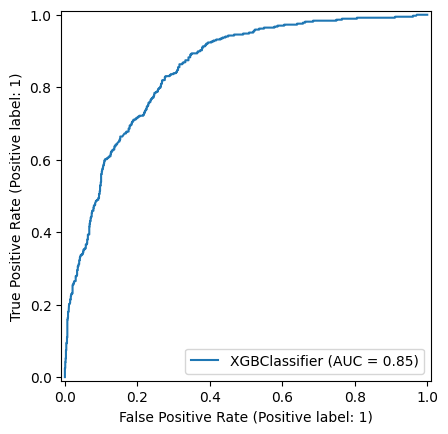

In [24]:
clf = xgbm_auto.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   clf, X_test, y_test)
plt.show()


In [25]:
# MSE on train set
mse_xgbm = np.mean((y_train - y_train_predict)**2)
print('train mse: ',mse_xgbm)
# MSE on test set

#Calculate MSE on test
test_mse_xgbm = np.mean((y_test - y_test_predict)**2)
print('test mse: ',test_mse_xgbm)

train mse:  0.17946894262683735
test mse:  0.19047619047619047


In [26]:
# Feature importance list
feature_names = list(X_train.columns)
feature_imp = pd.DataFrame(
    {'importance':xgbm_auto.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Contract_Month-to-month,0.434916
InternetService_Fiber optic,0.154758
TechSupport_No,0.077234
OnlineSecurity_No,0.057682
PaymentMethod_Electronic check,0.039356
StreamingMovies_Yes,0.028000
Contract_One year,0.027597
tenure,0.024874
Contract_Two year,0.022520
StreamingMovies_No,0.013857


In [27]:
# classification report with test regarding F1 score and accuracy
target_names = ['Retained','Churned']
print(sklearn.metrics.classification_report(y_test, y_test_predict, output_dict=False, target_names=target_names))

              precision    recall  f1-score   support

    Retained       0.85      0.90      0.87      1041
     Churned       0.66      0.55      0.60       366

    accuracy                           0.81      1407
   macro avg       0.76      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



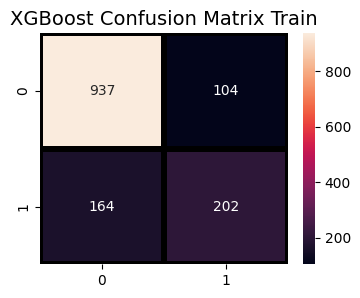

In [28]:
# heatmap and confusion matrix of test
# Include or replace w/ROC curve

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, y_test_predict),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("XGBoost Confusion Matrix Train",fontsize=14)
plt.show()

In [29]:
# MCC
#  MCC

from sklearn.metrics import matthews_corrcoef
#from sklearn.metrics import confusion_matrix


# Example usage with confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_predict)
tn, fp, fn, tp = conf_matrix.ravel()

mcc_manual = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))**0.5
print(f"Manually Calculated MCC: {mcc_manual}")

Manually Calculated MCC: 0.4806824446115444
